In [1]:
pip install --upgrade fosforml

Requirement already up-to-date: fosforml in /opt/conda/lib/python3.9/site-packages (1.1.8)
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade numpy

  Using cached https://files.pythonhosted.org/packages/b9/14/78635daab4b07c0930c919d451b8bf8c164774e6a3413aed04a6d95758ce/numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
ERROR: snowflake-ml-python 1.5.0 has requirement numpy<2,>=1.23, but you'll have numpy 2.0.2 which is incompatible.
ERROR: scikit-learn 1.3.2 has requirement numpy<2.0,>=1.17.3, but you'll have numpy 2.0.2 which is incompatible.
ERROR: catboost 1.2.7 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 2.0.2 which is incompatible.
  Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.9/site-packages (0.13.2)
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install pandas
!pip install snowflake-ml-python
!pip install requests

You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/54/30/c2a907b9443cf42b90c17ad10c1e8fa801975f01cb9764f3f8eb8aea638b/numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
# pip install ydata-profiling --upgrade

In [6]:
import pandas as pd
import numpy as np
import fosforml
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

In [8]:
my_session.connection.database

'ASSORTMENT_PLANNING'

In [9]:
my_session.connection.schema

'CPG_BRONZE'

In [10]:
table_name = "ASSORTMENT_PLANNING.CPG_BRONZE.SALES_CLEAN"

In [11]:
sf_df = my_session.sql("select * from {}".format(table_name))

In [12]:
type(sf_df)

snowflake.snowpark.dataframe.DataFrame

In [13]:
df=sf_df.to_pandas()

In [14]:
type(df)

pandas.core.frame.DataFrame

In [15]:
df.head(5)

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND
0,202312,2023-12-26,2023-11-27,372.73,2,0.000650,372.727273,202212,DB0110,OL112848,Carbondale,Illinois,City Center,Str2,PRD0118,Soap,Medicated Soap,Burgundy
1,202312,2023-12-26,2023-11-27,436.36,3,0.000900,436.363636,202212,DB0110,OL112848,Carbondale,Illinois,City Center,Str2,PRD0131,Soap,Toilet Soap,Grape vine
2,202312,2023-12-24,2023-11-27,202.82,2,0.000214,209.090909,202212,DB0209,OL112555,Shelbyville,Tennessee,City Center,Str5,PRD0065,Hair Care,Hair Oil,Crimson
3,202312,2023-12-29,2023-11-27,142.86,16,0.000384,142.857143,202212,DB0655,OL113173,Renton,Washington,Orange,Str2,PRD0106,Hair Care,Shampoo,Hair & Shoulders
4,202312,2023-12-17,2023-11-27,145.45,1,0.000300,145.454545,202212,DB0652,OL112373,Wallingford,Connecticut,Dolphin,Str1,PRD0070,Perfume and Deodrants,Female Deodrant,Pista green


In [16]:
df.shape

(966400, 18)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966400 entries, 0 to 966399
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MNTH_CODE         966400 non-null  int32  
 1   TRANS_DATE        966400 non-null  object 
 2   START_DATE        966400 non-null  object 
 3   SALES_VALUE       966400 non-null  float64
 4   SALES_UNITS       966400 non-null  int16  
 5   SALES_VOLUME      966400 non-null  float64
 6   SALES_PTR_VALUE   966400 non-null  float64
 7   OC_CODE           966400 non-null  int32  
 8   DISTRIBUTOR_CODE  966400 non-null  object 
 9   OUTLET_CODE       966400 non-null  object 
 10  CITY              966400 non-null  object 
 11  STATE             966400 non-null  object 
 12  COUNTY            966400 non-null  object 
 13  STREET            966400 non-null  object 
 14  PRODUCT_CODE      966400 non-null  object 
 15  CATEGORY          966400 non-null  object 
 16  SUBCATEGORY       96

## Converting to datetime data type

In [18]:
df['TRANS_DATE'] = pd.to_datetime(df['TRANS_DATE'])
df['START_DATE'] = pd.to_datetime(df['START_DATE'])

In [19]:
df.describe()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE
count,966400.000000,966400,966400,966400.000000,966400.000000,966400.000000,966400.000000,966400.000000
mean,202372.876450,2024-03-01 03:47:10.976821504,2024-02-14 23:17:36.278145536,446.417454,12.696476,0.000931,457.814679,202206.573263
min,202309.000000,2023-08-29 00:00:00,2023-08-28 00:00:00,2.860000,1.000000,0.000011,1.785714,202201.000000
25%,202312.000000,2023-11-30 00:00:00,2023-11-27 00:00:00,140.000000,2.000000,0.000368,142.857143,202204.000000
50%,202403.000000,2024-03-03 00:00:00,2024-02-27 00:00:00,192.240000,6.000000,0.000448,198.181818,202207.000000
75%,202406.000000,2024-06-04 00:00:00,2024-05-29 00:00:00,450.000000,16.000000,0.000900,450.000000,202209.000000
max,202408.000000,2024-08-27 00:00:00,2024-07-31 00:00:00,145728.120000,10240.000000,0.275500,151800.000000,202212.000000
std,44.525843,NaN,NaN,1053.355633,40.761336,0.002063,1101.769102,3.404526


In [20]:
df.columns

Index(['MNTH_CODE', 'TRANS_DATE', 'START_DATE', 'SALES_VALUE', 'SALES_UNITS',
       'SALES_VOLUME', 'SALES_PTR_VALUE', 'OC_CODE', 'DISTRIBUTOR_CODE',
       'OUTLET_CODE', 'CITY', 'STATE', 'COUNTY', 'STREET', 'PRODUCT_CODE',
       'CATEGORY', 'SUBCATEGORY', 'BRAND'],
      dtype='object')

In [21]:
df.isnull().sum()

MNTH_CODE           0
TRANS_DATE          0
START_DATE          0
SALES_VALUE         0
SALES_UNITS         0
SALES_VOLUME        0
SALES_PTR_VALUE     0
OC_CODE             0
DISTRIBUTOR_CODE    0
OUTLET_CODE         0
CITY                0
STATE               0
COUNTY              0
STREET              0
PRODUCT_CODE        0
CATEGORY            0
SUBCATEGORY         0
BRAND               0
dtype: int64

In [22]:
df.duplicated().sum()

3158

In [23]:
# Find unique dates
df['TRANS_DATE'].nunique()

303

In [24]:
# Create features from date column
df['YEAR'] = df['TRANS_DATE'].dt.year
df['MONTH'] = df['TRANS_DATE'].dt.month
df['DAY'] = df['TRANS_DATE'].dt.day
df['DAY_OF_WEEK'] = df['TRANS_DATE'].dt.day_of_week + 1 # Monday is 1 and sunday is 7
df['QUARTER'] = df['TRANS_DATE'].dt.quarter
df['DAY_OF_YEAR'] = df['TRANS_DATE'].dt.dayofyear

In [25]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

In [26]:
df.head(5)

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR
0,202312,2023-12-26,2023-11-27,372.73,2,0.000650,372.727273,202212,DB0110,OL112848,Carbondale,Illinois,City Center,Str2,PRD0118,Soap,Medicated Soap,Burgundy,2023,12,26,2,4,360
1,202312,2023-12-26,2023-11-27,436.36,3,0.000900,436.363636,202212,DB0110,OL112848,Carbondale,Illinois,City Center,Str2,PRD0131,Soap,Toilet Soap,Grape vine,2023,12,26,2,4,360
2,202312,2023-12-24,2023-11-27,202.82,2,0.000214,209.090909,202212,DB0209,OL112555,Shelbyville,Tennessee,City Center,Str5,PRD0065,Hair Care,Hair Oil,Crimson,2023,12,24,7,4,358
3,202312,2023-12-29,2023-11-27,142.86,16,0.000384,142.857143,202212,DB0655,OL113173,Renton,Washington,Orange,Str2,PRD0106,Hair Care,Shampoo,Hair & Shoulders,2023,12,29,5,4,363
4,202312,2023-12-17,2023-11-27,145.45,1,0.000300,145.454545,202212,DB0652,OL112373,Wallingford,Connecticut,Dolphin,Str1,PRD0070,Perfume and Deodrants,Female Deodrant,Pista green,2023,12,17,7,4,351


In [27]:
'''from ydata_profiling import ProfileReport
profile=ProfileReport(df,explorative=True)
profile.to_file("autoeda_v1.html")'''

'from ydata_profiling import ProfileReport\nprofile=ProfileReport(df,explorative=True)\nprofile.to_file("autoeda_v1.html")'

In [28]:
df_dup = df[df.duplicated()].sort_values(by=['TRANS_DATE','SALES_UNITS','OUTLET_CODE'])

In [29]:
df_unique = df.drop_duplicates()

In [30]:
df_unique.shape

(963242, 24)

In [31]:
df_check = df_unique.sort_values(by='TRANS_DATE')
df_check.head()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR
800555,202309,2023-08-29,2023-08-28,618.18,2,0.001800,618.181818,202209,DB0209,OL191210,Stoughton,Massachusetts,City Center,Str5,PRD0100,Perfume and Deodrants,Unisex Deodrant,Ash,2023,8,29,2,3,241
45118,202309,2023-08-29,2023-08-28,137.14,16,0.000272,142.857143,202209,DB0209,OL190758,Chapel Hill,North Carolina,City Center,Str1,PRD0028,Soap,Toilet Soap,Indigo,2023,8,29,2,3,241
45119,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,DB0209,OL33423,Ludlow,Massachusetts,Scott,Str5,PRD0112,Soap,Toilet Soap,Lemon yellow,2023,8,29,2,3,241
45120,202309,2023-08-29,2023-08-28,448.64,3,0.002700,477.272727,202209,DB0110,OL144399,Newton,Kansas,City Center,Str3,PRD0041,Soap,Beauty Soap,Charcoal,2023,8,29,2,3,241
45121,202309,2023-08-29,2023-08-28,336.36,2,0.000770,336.363636,202209,DB0706,OL128757,Rhinelander,Wisconsin,City Center,Str3,PRD0016,Hair Care,Hair Oil,Magenta,2023,8,29,2,3,241


In [32]:
df_all_dates = pd.date_range(start='2023-08-29', end='2024-08-27').tolist()

In [33]:
missing_dates=set(df_all_dates) - set(df_unique['TRANS_DATE'])
len(missing_dates)

62

In [34]:
# Calculate the week number for each date
df_check['WEEK_NUMBER'] = df_check['TRANS_DATE'].dt.isocalendar().week

In [35]:
df_check.head()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR,WEEK_NUMBER
800555,202309,2023-08-29,2023-08-28,618.18,2,0.001800,618.181818,202209,DB0209,OL191210,Stoughton,Massachusetts,City Center,Str5,PRD0100,Perfume and Deodrants,Unisex Deodrant,Ash,2023,8,29,2,3,241,35
45118,202309,2023-08-29,2023-08-28,137.14,16,0.000272,142.857143,202209,DB0209,OL190758,Chapel Hill,North Carolina,City Center,Str1,PRD0028,Soap,Toilet Soap,Indigo,2023,8,29,2,3,241,35
45119,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,DB0209,OL33423,Ludlow,Massachusetts,Scott,Str5,PRD0112,Soap,Toilet Soap,Lemon yellow,2023,8,29,2,3,241,35
45120,202309,2023-08-29,2023-08-28,448.64,3,0.002700,477.272727,202209,DB0110,OL144399,Newton,Kansas,City Center,Str3,PRD0041,Soap,Beauty Soap,Charcoal,2023,8,29,2,3,241,35
45121,202309,2023-08-29,2023-08-28,336.36,2,0.000770,336.363636,202209,DB0706,OL128757,Rhinelander,Wisconsin,City Center,Str3,PRD0016,Hair Care,Hair Oil,Magenta,2023,8,29,2,3,241,35


In [36]:
# Calculate the year difference from the first date
df_check['YEAR_DIFF'] = df_check['TRANS_DATE'].dt.year - df_check['TRANS_DATE'].dt.year.min()

# Calculate the continuous week number
df_check['CONTINUOUS_WEEK_NUMBER'] = df_check['WEEK_NUMBER'] + df_check['YEAR_DIFF'] * 52

# Adjust for the first year weeks
first_year_weeks = df_check[df_check['YEAR_DIFF'] == 0]['WEEK_NUMBER'].max()
df_check['CONTINUOUS_WEEK_NUMBER'] = df_check.apply(
    lambda row: row['CONTINUOUS_WEEK_NUMBER'] - (52 - first_year_weeks) if row['YEAR_DIFF'] > 0 else row['CONTINUOUS_WEEK_NUMBER'],
    axis=1
)
df_check['CONTINUOUS_WEEK_NUMBER']=df_check['CONTINUOUS_WEEK_NUMBER']-34

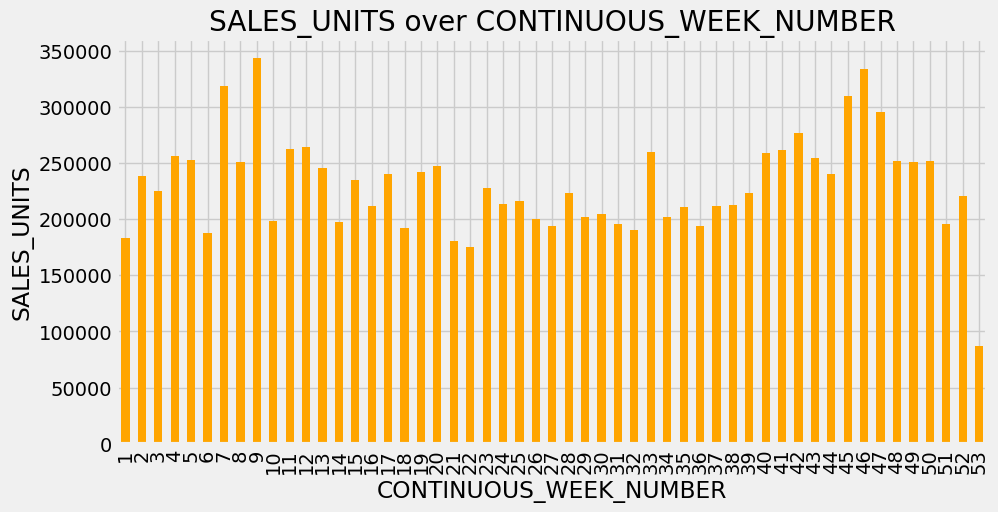

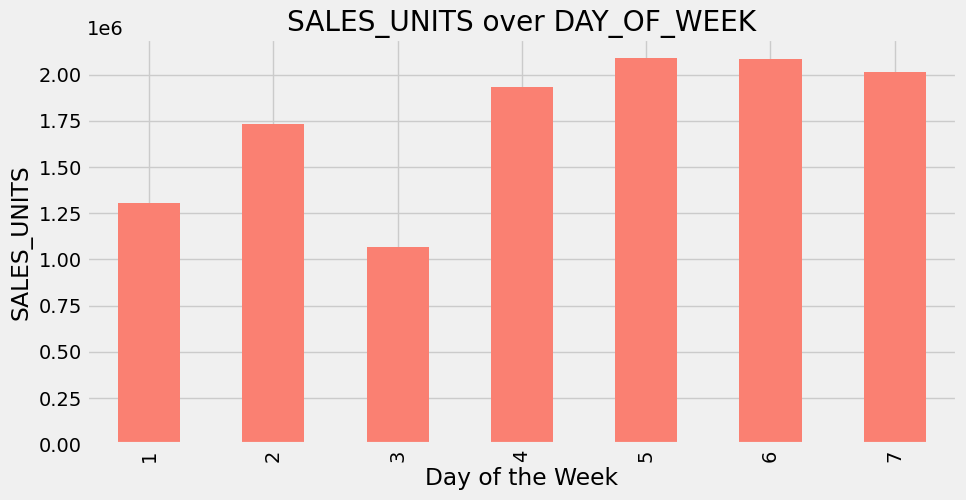

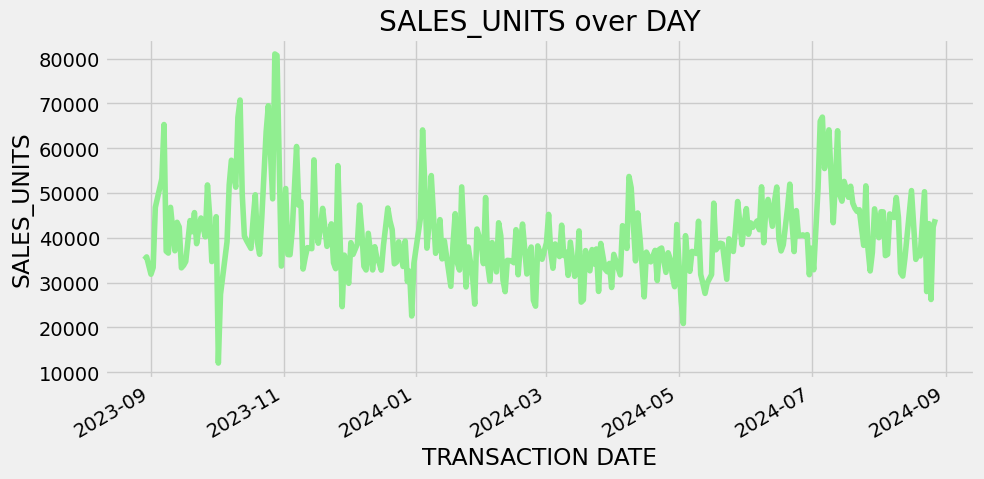

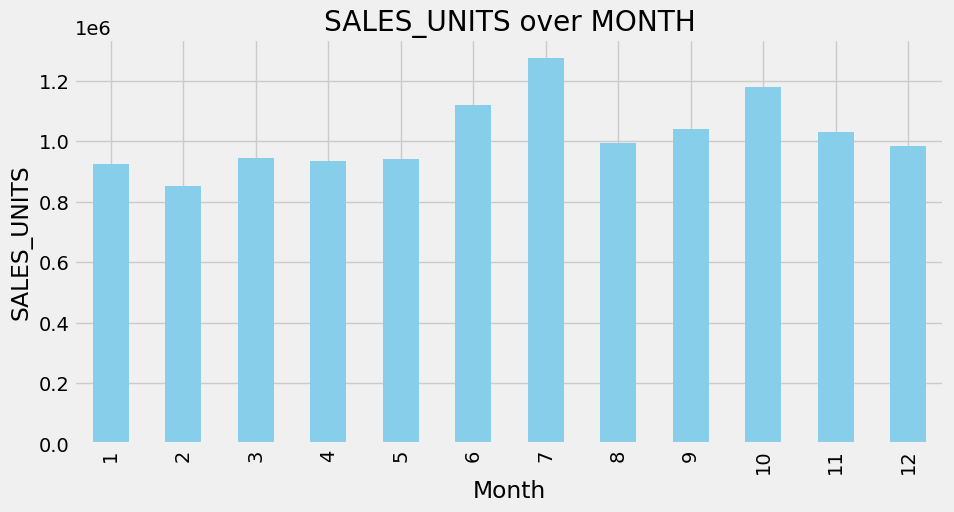

In [37]:
import matplotlib.pyplot as plt

# Plot SALES_UNITS over CONTINUOUS_WEEK_NUMBER
plt.figure(figsize=(10, 5))
df_check.groupby('CONTINUOUS_WEEK_NUMBER')['SALES_UNITS'].sum().plot(kind='bar', color='orange')
plt.title('SALES_UNITS over CONTINUOUS_WEEK_NUMBER')
plt.xlabel('CONTINUOUS_WEEK_NUMBER')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()

# Plot SALES_UNITS over DAY_OF_WEEK
plt.figure(figsize=(10, 5))
df_check.groupby('DAY_OF_WEEK')['SALES_UNITS'].sum().plot(kind='bar', color='salmon')
plt.title('SALES_UNITS over DAY_OF_WEEK')
plt.xlabel('Day of the Week')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()

# Plot SALES_UNITS over TRANSACTION DATE
plt.figure(figsize=(10, 5))
df_check.groupby('TRANS_DATE')['SALES_UNITS'].sum().plot(kind='line', color='lightgreen')
plt.title('SALES_UNITS over DAY')
plt.xlabel('TRANSACTION DATE')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
# Plot SALES_UNITS over MONTH
plt.figure(figsize=(10, 5))
df_check.groupby('MONTH')['SALES_UNITS'].sum().plot(kind='bar', color='skyblue')
plt.title('SALES_UNITS over MONTH')
plt.xlabel('Month')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()

In [38]:
df_final = df_check.drop(['WEEK_NUMBER'],axis=1)

In [39]:
df_final.tail()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR,YEAR_DIFF,CONTINUOUS_WEEK_NUMBER
73548,202408,2024-08-27,2024-07-31,137.14,16,0.000416,142.857143,202208,DB0110,OL113285,Watertown,South Dakota,City Center,Str2,PRD0069,Perfume and Deodrants,Female Deodrant,Arctic blue,2024,8,27,2,3,240,1,53
910296,202408,2024-08-27,2024-07-31,142.86,16,0.000384,142.857143,202208,DB0706,OL160311,Hanover,Pennsylvania,Scott,Str4,PRD0106,Hair Care,Shampoo,Hair & Shoulders,2024,8,27,2,3,240,1,53
886932,202408,2024-08-27,2024-07-31,162.73,1,0.000300,162.727273,202208,DB0655,OL33810,Pontiac,Illinois,Dolphin,Str2,PRD0078,Lotion,Head Lotion,Saffron,2024,8,27,2,3,240,1,53
920393,202408,2024-08-27,2024-07-31,304.23,3,0.000321,313.636364,202208,DB0110,OL113302,Pascagoula,Mississippi,City Center,Str3,PRD0158,Perfume and Deodrants,Female Perfume,Emerald,2024,8,27,2,3,240,1,53
137754,202408,2024-08-27,2024-07-31,1010.10,6,0.002310,1009.090909,202208,DB0655,OL12331,Seward,Alaska,City Center,Str3,PRD0016,Hair Care,Hair Oil,Magenta,2024,8,27,2,3,240,1,53


In [40]:
df_final['OUTLET_CODE'].nunique()

18833

In [41]:
# # In case cluster column exists, uncomment this
#df_final = df_final.drop(columns=['CLUSTER'])


In [42]:
## Additional Features

df_final['FREQUENCY'] = df_final.groupby(['OUTLET_CODE', 'PRODUCT_CODE']).cumcount() + 1

df_final['PROFIT_PER_UNIT'] = (df_final['SALES_PTR_VALUE'] - df_final['SALES_VALUE']) / df_final['SALES_UNITS']

df_final['DAYS_BETWEEN'] = df_final.groupby(['OUTLET_CODE', 'PRODUCT_CODE'])['TRANS_DATE'].diff().dt.days
df_final['DAYS_BETWEEN'] = df_final['DAYS_BETWEEN'].fillna(0)

df_final['UNIT_PTR'] = df_final['SALES_PTR_VALUE']/df_final['SALES_UNITS']


In [43]:
df_final[(df_final['PRODUCT_CODE'] == 'PRD0147') & (df_final['OUTLET_CODE'] == 'OL160188')].head()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR,YEAR_DIFF,CONTINUOUS_WEEK_NUMBER,FREQUENCY,PROFIT_PER_UNIT,DAYS_BETWEEN,UNIT_PTR
779128,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,DB0209,OL160188,Oneida,New York,Silver,Str4,PRD0147,Kids Care,Baby Cream,Mint,2023,8,29,2,3,241,0,1,1,-0.000179,0.0,8.928571
733082,202404,2024-04-11,2024-04-03,142.86,16,0.000400,142.857143,202204,DB0209,OL160188,Oneida,New York,Silver,Str4,PRD0147,Kids Care,Baby Cream,Mint,2024,4,11,4,2,102,1,33,2,-0.000179,226.0,8.928571
429762,202407,2024-07-25,2024-07-03,142.84,16,0.000384,142.857143,202207,DB0209,OL160188,Oneida,New York,Silver,Str4,PRD0147,Kids Care,Baby Cream,Mint,2024,7,25,4,3,207,1,48,3,0.001071,105.0,8.928571


In [44]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# List of columns to encode
columns_to_encode = ['BRAND', 'PRODUCT_CODE', 'SUBCATEGORY', 'CITY','STATE', 'COUNTY']

# Apply label encoding to each column
for column in columns_to_encode:
    df_final[column + '_encoded'] = label_encoder.fit_transform(df_final[column])

df_final = pd.get_dummies(df_final, columns=['DISTRIBUTOR_CODE', 'CATEGORY'])

# Convert all column names to uppercase and replace spaces with underscores
df_final.columns = df_final.columns.str.upper().str.replace(' ', '_')

In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_final
# Convert all column names to uppercase and replace spaces with underscores
df_final.columns = df_final.columns.str.upper().str.replace(' ', '_')

# List of one-hot encoded category columns
category_columns = [
    'CATEGORY_DENTAL', 'CATEGORY_HAIR_CARE', 'CATEGORY_KIDS_CARE',
    'CATEGORY_LOTION', 'CATEGORY_PERFUME_AND_DEODRANTS', 'CATEGORY_SOAP', 'CATEGORY_WIPES'
]

# Aggregate data by OUTLET_CODE, including one-hot encoded category columns
aggregation_dict = {
    'SALES_UNITS': 'mean',
    'PROFIT_PER_UNIT': 'mean',
    'FREQUENCY': 'count'
}
aggregation_dict.update({col: 'max' for col in category_columns})

aggregated_df = df_final.groupby('OUTLET_CODE').agg(aggregation_dict).reset_index()

# Select features for clustering
features = ['SALES_UNITS', 'PROFIT_PER_UNIT', 'FREQUENCY'] + category_columns

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['SALES_UNITS', 'PROFIT_PER_UNIT', 'FREQUENCY']),
        # No need to preprocess category columns as they are already one-hot encoded
    ],
    remainder='passthrough'  # Keep the one-hot encoded columns as they are
)

# Preprocess the data
df_preprocessed = preprocessor.fit_transform(aggregated_df[features])


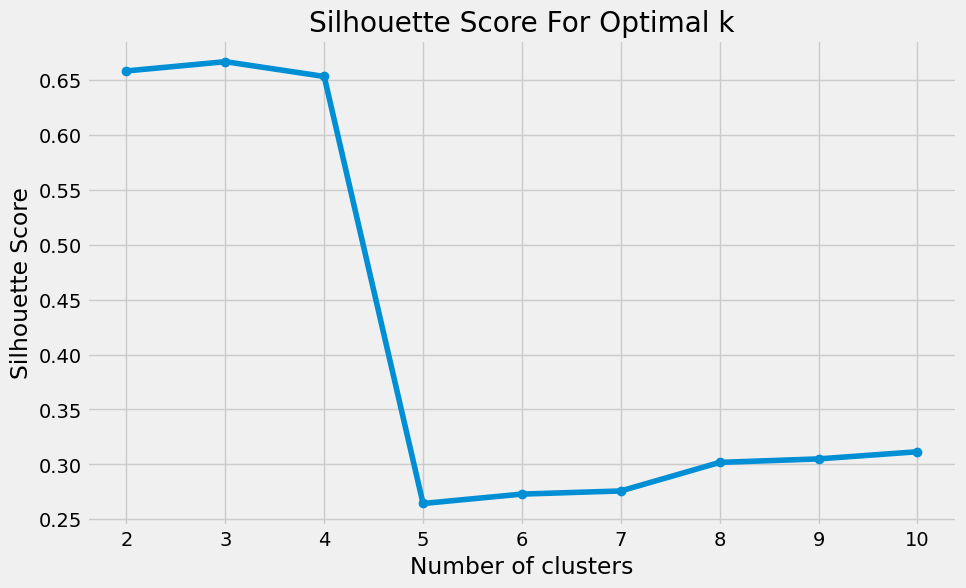

In [46]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
k_range = range(2, 11)  # Silhouette score is not defined for k=1
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_preprocessed)
    silhouette_avg = silhouette_score(df_preprocessed, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

In [47]:
# Apply K-Means clustering with the chosen number of clusters 
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]  # Choose the k with the highest silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
aggregated_df['CLUSTER'] = kmeans.fit_predict(df_preprocessed)

# Display the first few rows to verify
print(aggregated_df.head())

  OUTLET_CODE  SALES_UNITS  PROFIT_PER_UNIT  FREQUENCY  CATEGORY_DENTAL  \
0     OL10328     6.500000         1.352202         34             True   
1     OL10329     5.887179         1.478946        195             True   
2     OL10330     5.520073         2.928942        548             True   
3     OL10331     1.775510         0.937763         49             True   
4     OL10332    28.598639         0.228253        147             True   

   CATEGORY_HAIR_CARE  CATEGORY_KIDS_CARE  CATEGORY_LOTION  \
0                True                True             True   
1                True                True             True   
2                True                True             True   
3                True                True             True   
4                True                True            False   

   CATEGORY_PERFUME_AND_DEODRANTS  CATEGORY_SOAP  CATEGORY_WIPES  CLUSTER  
0                            True           True           False        0  
1                       

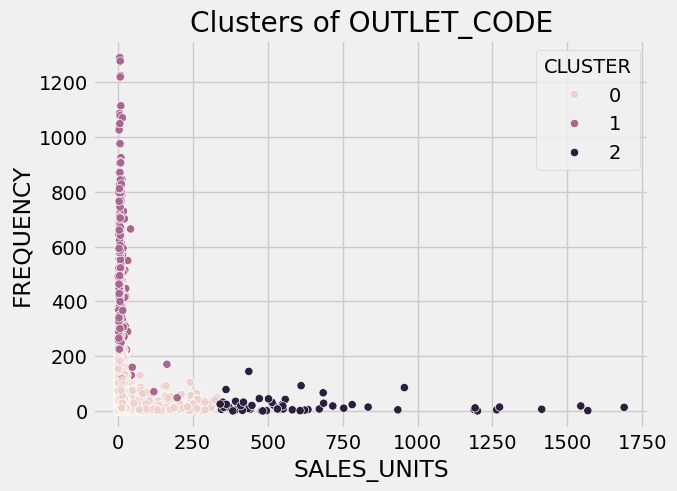

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example visualization Clusters of SALES_UNITS VS SALES_VALUE
sns.scatterplot(x='SALES_UNITS', y='FREQUENCY', hue='CLUSTER', data=aggregated_df)
plt.title('Clusters of OUTLET_CODE')
plt.show()

In [49]:
df_final_with_clusters = df_final.merge(aggregated_df[['OUTLET_CODE', 'CLUSTER']], on='OUTLET_CODE', how='left')
df_final_with_clusters.head()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR,YEAR_DIFF,CONTINUOUS_WEEK_NUMBER,FREQUENCY,PROFIT_PER_UNIT,DAYS_BETWEEN,UNIT_PTR,BRAND_ENCODED,PRODUCT_CODE_ENCODED,SUBCATEGORY_ENCODED,CITY_ENCODED,STATE_ENCODED,COUNTY_ENCODED,DISTRIBUTOR_CODE_DB0110,DISTRIBUTOR_CODE_DB0209,DISTRIBUTOR_CODE_DB0652,DISTRIBUTOR_CODE_DB0655,DISTRIBUTOR_CODE_DB0706,CATEGORY_DENTAL,CATEGORY_HAIR_CARE,CATEGORY_KIDS_CARE,CATEGORY_LOTION,CATEGORY_PERFUME_AND_DEODRANTS,CATEGORY_SOAP,CATEGORY_WIPES,CLUSTER
0,202309,2023-08-29,2023-08-28,618.18,2,0.001800,618.181818,202209,OL191210,Stoughton,Massachusetts,City Center,Str5,PRD0100,Unisex Deodrant,Ash,2023,8,29,2,3,241,0,1,1,0.000909,0.0,309.090909,5,56,22,1441,20,0,False,True,False,False,False,False,False,False,False,True,False,False,1
1,202309,2023-08-29,2023-08-28,137.14,16,0.000272,142.857143,202209,OL190758,Chapel Hill,North Carolina,City Center,Str1,PRD0028,Toilet Soap,Indigo,2023,8,29,2,3,241,0,1,1,0.357321,0.0,8.928571,32,14,18,255,32,0,False,True,False,False,False,False,False,False,False,False,True,False,1
2,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,OL33423,Ludlow,Massachusetts,Scott,Str5,PRD0112,Toilet Soap,Lemon yellow,2023,8,29,2,3,241,0,1,1,-0.000179,0.0,8.928571,39,62,18,859,20,4,False,True,False,False,False,False,False,False,False,False,True,False,0
3,202309,2023-08-29,2023-08-28,448.64,3,0.002700,477.272727,202209,OL144399,Newton,Kansas,City Center,Str3,PRD0041,Beauty Soap,Charcoal,2023,8,29,2,3,241,0,1,1,9.544242,0.0,159.090909,12,23,2,1044,15,0,True,False,False,False,False,False,False,False,False,False,True,False,1
4,202309,2023-08-29,2023-08-28,336.36,2,0.000770,336.363636,202209,OL128757,Rhinelander,Wisconsin,City Center,Str3,PRD0016,Hair Oil,Magenta,2023,8,29,2,3,241,0,1,1,0.001818,0.0,168.181818,45,9,9,1260,48,0,False,False,False,False,True,False,True,False,False,False,False,False,0


In [50]:
df_featureset = df_final_with_clusters.copy()

In [51]:
# df_featureset.drop(['OC_CODE','OUTLET_CODE','PRODUCT_CODE','STREET','CITY','STATE','COUNTY','PRODUCT_CODE','SUBCATEGORY','BRAND'], axis=1, inplace=True)

In [52]:
df_featureset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963242 entries, 0 to 963241
Data columns (total 47 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   MNTH_CODE                       963242 non-null  int32         
 1   TRANS_DATE                      963242 non-null  datetime64[ns]
 2   START_DATE                      963242 non-null  datetime64[ns]
 3   SALES_VALUE                     963242 non-null  float64       
 4   SALES_UNITS                     963242 non-null  int16         
 5   SALES_VOLUME                    963242 non-null  float64       
 6   SALES_PTR_VALUE                 963242 non-null  float64       
 7   OC_CODE                         963242 non-null  int32         
 8   OUTLET_CODE                     963242 non-null  object        
 9   CITY                            963242 non-null  object        
 10  STATE                           963242 non-null  object 

In [53]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# Separate features and target
X = df_featureset.drop('SALES_UNITS', axis=1)
y = df_featureset['SALES_UNITS']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df_featureset is your DataFrame

# Define features and target
features = [
    'YEAR', 
    'MONTH', 'DAY', 'DAY_OF_WEEK', 'DAY_OF_YEAR', 'FREQUENCY',
    'BRAND_ENCODED', 'PRODUCT_CODE_ENCODED', 'SUBCATEGORY_ENCODED', 'CITY_ENCODED',
    'STATE_ENCODED',
    # 'COUNTY_ENCODED', 
    # 'DISTRIBUTOR_CODE_DB0110', 'DISTRIBUTOR_CODE_DB0209',
    # 'DISTRIBUTOR_CODE_DB0652', 'DISTRIBUTOR_CODE_DB0655', 'DISTRIBUTOR_CODE_DB0706',
    # # 'CATEGORY_DENTAL', 'CATEGORY_HAIR_CARE', 'CATEGORY_KIDS_CARE', 'CATEGORY_LOTION',
    # 'CATEGORY_PERFUME_AND_DEODRANTS', 'CATEGORY_SOAP', 'CATEGORY_WIPES', 
    'CLUSTER','UNIT_PTR'
]
target = 'SALES_UNITS'

# Split the data into training and testing sets based on MNTH_CODE
train_data = df_featureset[df_featureset['MNTH_CODE'] != 202408]
test_data = df_featureset[df_featureset['MNTH_CODE'] == 202408]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Initialize and train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Display feature importances
feature_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

In [ ]:
# Create a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

comparison_df.tail()

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score

# Assuming y_test and y_pred are your actual and predicted values respectively

# Define a threshold to convert continuous predictions to binary labels
threshold = 10  # Example threshold

# Convert to binary labels based on the threshold
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = (y_pred >= threshold).astype(int)

# Compute precision and recall
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

In [ ]:
# import pandas as pd

# # Assuming X_test is your test features DataFrame
# # And comparison_df is your DataFrame containing actual and predicted values

# # Ensure the indices match
# comparison_df.index = X_test.index

# # Concatenate X_test with comparison_df
# merged_df = pd.concat([X_test, comparison_df], axis=1)

# # Display the first few rows to verify
# merged_df.head()


In [ ]:
# import pandas as pd
# from sklearn.metrics import precision_score, recall_score

# # Assuming y_test and y_pred are your actual and predicted values respectively
# # And comparison_df is your DataFrame containing actual and predicted values

# # Ensure y_test and y_pred are integers representing class labels
# y_test_multiclass = y_test.astype(int)
# y_pred_multiclass = y_pred.astype(int)

# # Calculate precision and recall for multiclass
# precision = precision_score(y_test_multiclass, y_pred_multiclass, average='macro')
# recall = recall_score(y_test_multiclass, y_pred_multiclass, average='macro')

# # Add precision and recall as columns to comparison_df
# comparison_df['PRECISION'] = precision
# comparison_df['RECALL'] = recall

# # Display the first few rows to verify
# comparison_df.head()


In [ ]:
# # Assuming the one-hot encoded columns are in merged_df
# # Create a mapping for distributor codes and categories
# distributor_columns = ['DISTRIBUTOR_CODE_DB0110', 'DISTRIBUTOR_CODE_DB0209', 'DISTRIBUTOR_CODE_DB0652', 'DISTRIBUTOR_CODE_DB0655', 'DISTRIBUTOR_CODE_DB0706']
# category_columns = ['CATEGORY_DENTAL', 'CATEGORY_HAIR_CARE', 'CATEGORY_KIDS_CARE', 'CATEGORY_LOTION', 'CATEGORY_PERFUME_AND_DEODRANTS', 'CATEGORY_SOAP', 'CATEGORY_WIPES']

# # Decode distributor codes
# merged_df['DISTRIBUTOR_CODE'] = merged_df[distributor_columns].idxmax(axis=1).str.replace('DISTRIBUTOR_CODE_', '')

# # Decode categories
# merged_df['CATEGORY'] = merged_df[category_columns].idxmax(axis=1).str.replace('CATEGORY_', '').str.replace('_', ' ')

# # Drop the one-hot encoded columns if no longer needed
# merged_df.drop(columns=distributor_columns + category_columns, inplace=True)

# # Display the first few rows to verify
# merged_df.head()


In [ ]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# # Assuming df_final is your DataFrame before encoding
# # Initialize the label encoder
# label_encoders = {}

# # List of columns to encode
# columns_to_encode = ['BRAND', 'PRODUCT_CODE', 'SUBCATEGORY', 'CITY', 'STATE', 'COUNTY']

# # Fit the label encoders with the original data
# for column in columns_to_encode:
#     le = LabelEncoder()
#     le.fit(df_final[column])
#     label_encoders[column] = le

# # Inverse transform the encoded columns in merged_df
# merged_df['BRAND'] = label_encoders['BRAND'].inverse_transform(merged_df['BRAND_ENCODED'])
# merged_df['PRODUCT_CODE'] = label_encoders['PRODUCT_CODE'].inverse_transform(merged_df['PRODUCT_CODE_ENCODED'])
# merged_df['SUBCATEGORY'] = label_encoders['SUBCATEGORY'].inverse_transform(merged_df['SUBCATEGORY_ENCODED'])
# merged_df['CITY'] = label_encoders['CITY'].inverse_transform(merged_df['CITY_ENCODED'])
# merged_df['STATE'] = label_encoders['STATE'].inverse_transform(merged_df['STATE_ENCODED'])
# merged_df['COUNTY'] = label_encoders['COUNTY'].inverse_transform(merged_df['COUNTY_ENCODED'])

In [ ]:
# # List of columns to drop
# columns_to_drop = ['BRAND_ENCODED', 'PRODUCT_CODE_ENCODED', 'SUBCATEGORY_ENCODED', 'CITY_ENCODED', 'STATE_ENCODED', 'COUNTY_ENCODED']

# # Drop the specified columns
# merged_df = merged_df.drop(columns=columns_to_drop)

# merged_df = merged_df.merge(df_final_with_clusters[['CITY', 'STATE', 'COUNTY', 'OUTLET_CODE']], on=['CITY', 'STATE', 'COUNTY'], how='left')

# merged_df.head()


In [ ]:
### Creating a Future dataset for all possible outlet code & product code combinations

In [ ]:
import pandas as pd
import itertools

# Assuming df is your DataFrame

# Extract unique values of OUTLET_CODE and PRODUCT_CODE
outlet_codes = df['OUTLET_CODE'].unique()
product_codes = df['PRODUCT_CODE'].unique()

# Generate all possible combinations of OUTLET_CODE and PRODUCT_CODE
combinations = list(itertools.product(outlet_codes, product_codes))

# Create a DataFrame from the combinations
future_df = pd.DataFrame(combinations, columns=['OUTLET_CODE', 'PRODUCT_CODE'])

# Display the first few rows to verify
print(future_df.head())



In [ ]:
# Group by OUTLET_CODE and count unique DISTRIBUTOR_CODE
distributor_counts = df.groupby('OUTLET_CODE')['DISTRIBUTOR_CODE'].nunique().reset_index()

# Rename the column for clarity
distributor_counts.rename(columns={'DISTRIBUTOR_CODE': 'UNIQUE_DISTRIBUTOR_COUNT'}, inplace=True)

# Determine if each OUTLET_CODE has multiple or a single DISTRIBUTOR_CODE
distributor_counts['DISTRIBUTOR_TYPE'] = distributor_counts['UNIQUE_DISTRIBUTOR_COUNT'].apply(lambda x: 'Multiple' if x > 1 else 'Single')
distributor_counts.head()


In [ ]:
print(distributor_counts['UNIQUE_DISTRIBUTOR_COUNT'].nunique())

In [ ]:
future_df.info()

In [ ]:
future_df = future_df.merge(df_final_with_clusters[['OUTLET_CODE', 'CLUSTER']], on='OUTLET_CODE', how='left')

In [ ]:
future_df = future_df.drop(columns=['OUTLET_CODE'])

In [ ]:
future_df.info()

In [ ]:
product_cluster_df = df_final_with_clusters[['PRODUCT_CODE', 'CLUSTER']]

In [ ]:
product_cluster.info()

In [ ]:
# Perform set difference to subtract product_cluster_df from future_df
difference_df = future_df.merge(product_cluster_df, on=['PRODUCT_CODE', 'CLUSTER'], how='left', indicator=True)
difference_df = difference_df[difference_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [ ]:
# import pandas as pd

# # Assuming df and future_df are your DataFrames

# # Merge the DISTRIBUTOR_CODE column from df with future_df
# future_df = future_df.merge(df[['OUTLET_CODE', 'DISTRIBUTOR_CODE']], on='OUTLET_CODE', how='left')
# future_df = future_df.merge(df_final[['PRODUCT_CODE', 'UNIT_PTR']], on='PRODUCT_CODE', how='left')

# # Display the first few rows to verify
# print(future_df.head())

In [ ]:
# # Merge the CLUSTER column from df with future_df
# future_df = future_df.merge(df_final_with_clusters[['OUTLET_CODE','CLUSTER']], on='OUTLET_CODE', how='left')

# # Display the first few rows to verify
# print(future_df.head())